# Import Libraries

In [2]:
!pip install xgboost
!pip install pandas scikit-learn
!pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import hashlib

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier

# Loading Data

In [3]:
Fraud = pd.read_csv ('Fraudulent.csv')
Fraud.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


In [29]:
Fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  Transaction Hou

# Preprocessing Data

In [30]:
Fraud.shape

(1472952, 16)

In [31]:
# Check duplicate data

Fraud.duplicated().sum()

0

In [32]:
# Check Missing values

Fraud.isnull().sum().reset_index()

,index,0
0,Transaction ID,0
1,Customer ID,0
2,Transaction Amount,0
3,Transaction Date,0
4,Payment Method,0
5,Product Category,0
6,Quantity,0
7,Customer Age,0
8,Customer Location,0
9,Device Used,0


- The dataset has **1,472,952 rows** and **16 columns**.
- There are **no missing values or duplicated data**.
- There are 5 columns of type int64, 1 column of type float64, and 10 columns of type object.
- 'Is Fraudulent' is the target variable indicating whether a transaction is fraudulent or not, with **0 indicating not fraudulent** and **1 indicating fraudulent**.

In [7]:
# Convert 'Transaction Date' to datetime
Fraud['Transaction Date'] = pd.to_datetime(Fraud['Transaction Date'])

# Formatting 'Transaction Date' to YYYY-MM-DD
Fraud['Transaction Date'] = Fraud['Transaction Date'].dt.strftime('%Y-%m-%d')

# Convert 'Transaction Date' back to datetime
Fraud['Transaction Date'] = pd.to_datetime(Fraud['Transaction Date'])

# Split column into Year, Month, and Day
Fraud['Transaction Year'] = Fraud['Transaction Date'].dt.year
Fraud['Transaction Month'] = Fraud['Transaction Date'].dt.month_name()
Fraud['Transaction Day'] = Fraud['Transaction Date'].dt.day

# Rearrange the columns as specified
cols = ['Transaction ID','Customer ID','Transaction Date','Transaction Year','Transaction Month','Transaction Day', 'Transaction Hour','Product Category','Quantity','Payment Method','Device Used', 'Customer Age','Customer Location','IP Address', 'Shipping Address','Billing Address','Account Age Days','Transaction Amount','Is Fraudulent']
Fraud_1= Fraud[cols]
Fraud_1

,Transaction ID,Customer ID,Transaction Date,Transaction Year,Transaction Month,Transaction Day,Transaction Hour,Product Category,Quantity,Payment Method,Device Used,Customer Age,Customer Location,IP Address,Shipping Address,Billing Address,Account Age Days,Transaction Amount,Is Fraudulent
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,2024-02-20,2024,February,20,5,electronics,1,bank transfer,tablet,17,Amandaborough,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,30,58.09,0
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,2024-02-25,2024,February,25,8,electronics,2,debit card,desktop,40,East Timothy,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",72,389.96,0
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,2024-03-18,2024,March,18,3,home & garden,2,PayPal,tablet,22,Davismouth,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",63,134.19,0
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,2024-03-16,2024,March,16,20,clothing,5,bank transfer,desktop,31,Lynnberg,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",124,226.17,0
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,2024-01-15,2024,January,15,5,clothing,2,bank transfer,tablet,51,South Nicole,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",158,121.53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472947,c8604004-2f4c-42ce-a1c4-cd2bebca79bb,f8a534ad-0458-465e-a85b-3ad2cdf391bc,2024-01-12,2024,January,12,23,health & beauty,2,PayPal,desktop,29,North Laurafort,27.245.104.92,USNV Griffin\nFPO AA 52700,USNV Griffin\nFPO AA 52700,149,208.48,0
1472948,fff0df19-fd4a-42a5-bc42-64bb7b02edb0,f2ef2239-d9b9-40d0-9993-4b8f305d5a7b,2024-03-27,2024,March,27,4,clothing,2,credit card,tablet,32,Burnsville,203.54.50.163,"478 John Square Apt. 235\nMillerhaven, GA 68797","478 John Square Apt. 235\nMillerhaven, GA 68797",132,231.57,0
1472949,9e79012f-e00b-47d1-8700-0c302db20d3e,fa5b9a25-9606-478a-8abe-ef20bbb3980f,2024-01-31,2024,January,31,23,electronics,4,bank transfer,mobile,36,Garciafort,51.241.30.149,"351 Frazier Radial Apt. 989\nPort Charles, OH ...","182 House Island Suite 198\nEast Scott, FM 84301",98,101.80,0
1472950,917066b1-4dfb-4472-b3f0-292663c45d21,04524272-e14f-460b-bc70-5316bd28463d,2024-01-12,2024,January,12,16,electronics,5,bank transfer,desktop,34,Lake Josephberg,210.67.203.4,"27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...","27307 Gonzalez Shore Suite 661\nPort Lynn, WV ...",191,61.80,0


In [34]:
# Mengelompokkan berdasarkan tipe
categoricals = ['Transaction ID','Customer ID','Transaction Date','Product Category','Payment Method','Device Used', 'Customer Location','IP Address', 'Shipping Address','Billing Address',]

numericals = ['Transaction Hour','Quantity', 'Customer Age','Account Age Days','Transaction Amount','Is Fraudulent']

## Handling Outlier

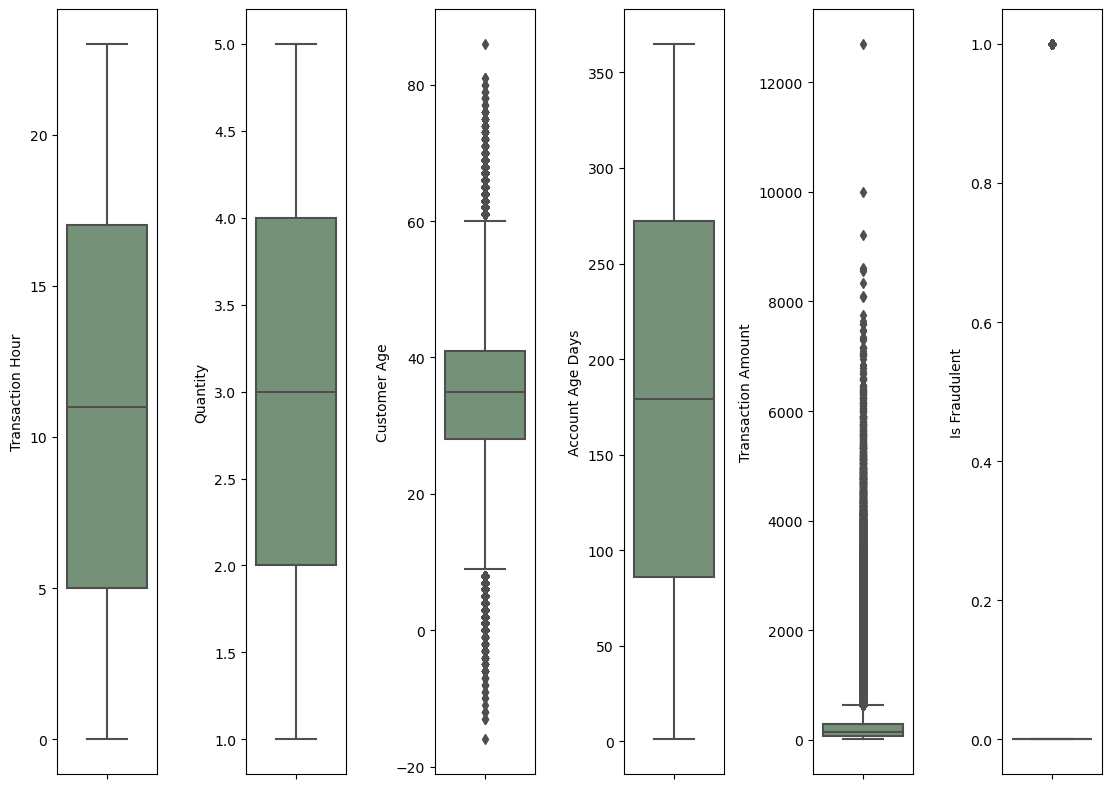

In [35]:
feat_num = list(Fraud_1[numericals])

plt.figure(figsize=(15, 8))
for i in range(0, len(feat_num)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=Fraud_1[numericals][feat_num[i]],color='#709775',orient='v')
    plt.tight_layout()

In [36]:
# check outlier
outlier = Fraud_1['Customer Age'].min()
Fraud_1[Fraud_1['Customer Age'] == outlier]

,Transaction ID,Customer ID,Transaction Date,Transaction Year,Transaction Month,Transaction Day,Transaction Hour,Product Category,Quantity,Payment Method,Device Used,Customer Age,Customer Location,IP Address,Shipping Address,Billing Address,Account Age Days,Transaction Amount,Is Fraudulent
291685,d7ea662d-4bec-4338-a6fd-8c9d2c2e40fb,b3e9468c-1c9d-4b8b-a42a-0bd2f44ff229,2024-01-23,2024,January,23,10,clothing,4,debit card,mobile,-16,Wilsonside,146.17.147.185,"3475 Steve Walk\nMelendezberg, GA 10815","3475 Steve Walk\nMelendezberg, GA 10815",232,220.94,0


Terdapat 1 outlier

In [37]:
# check outlier
outlier = Fraud_1['Transaction Amount'].min()
Fraud_1[Fraud_1['Transaction Amount'] == outlier]

,Transaction ID,Customer ID,Transaction Date,Transaction Year,Transaction Month,Transaction Day,Transaction Hour,Product Category,Quantity,Payment Method,Device Used,Customer Age,Customer Location,IP Address,Shipping Address,Billing Address,Account Age Days,Transaction Amount,Is Fraudulent
20065,7f9dd054-fc74-46c5-96a1-86319de98685,d7e893f6-90ab-4cf2-82dd-7ff5612a8dcb,2024-02-06,2024,February,6,10,electronics,2,credit card,desktop,41,Seanborough,202.167.171.58,"040 William View Suite 582\nValentinemouth, OR...","040 William View Suite 582\nValentinemouth, OR...",356,10.0,0
51709,0e234465-7bdd-4e0a-9e72-fb08f15773ea,857a6789-e677-4a0f-a40e-6c067c51f7a4,2024-03-25,2024,March,25,1,electronics,4,PayPal,tablet,38,Port Alfred,93.77.193.120,"29564 Zachary Glen Suite 911\nEast Keithview, ...","29564 Zachary Glen Suite 911\nEast Keithview, ...",4,10.0,1
115200,cb3c9a7b-e7d5-4ea3-a8b4-956dd2c832c1,9b549375-5c99-49d0-b457-c0a4de267df2,2024-01-19,2024,January,19,5,health & beauty,2,debit card,mobile,34,East Amanda,220.242.109.143,"149 Janet Lane Apt. 942\nSouth Barry, SC 05353","149 Janet Lane Apt. 942\nSouth Barry, SC 05353",101,10.0,0
233987,cb64e51e-0ed0-439c-abe8-1dd067f413c3,b7c217a2-b492-4a1c-adc0-d11f4ce6b0e3,2024-01-30,2024,January,30,7,home & garden,2,debit card,mobile,40,South Heather,27.217.86.165,8781 Gregory Junctions Apt. 031\nWest Christop...,8781 Gregory Junctions Apt. 031\nWest Christop...,307,10.0,0
445259,3954cecb-c1c7-4180-8397-e3481a0a3c44,db9e6c7d-a04c-492b-bea6-f7d4a1486004,2024-01-28,2024,January,28,20,clothing,3,bank transfer,mobile,36,Holmesfort,27.124.253.187,"9346 Watson Forge\nVaughnmouth, MP 15724","9346 Watson Forge\nVaughnmouth, MP 15724",361,10.0,0
453291,5b348887-2660-4492-b562-eac8f9bec652,49012cca-10bc-454e-9538-c47d245168a8,2024-03-17,2024,March,17,5,toys & games,1,PayPal,mobile,30,Cabrerachester,60.3.22.63,"5023 Gordon Trafficway Suite 887\nBensonfurt, ...","5023 Gordon Trafficway Suite 887\nBensonfurt, ...",140,10.0,0
567092,d2ce13ec-96d2-45f8-85cf-5424ade71449,6eaac245-bc46-4707-b089-9e853874856a,2024-03-19,2024,March,19,4,health & beauty,4,PayPal,mobile,22,Ashleyton,114.77.217.96,"48884 Ariel Summit\nJamesville, TN 98227","48884 Ariel Summit\nJamesville, TN 98227",107,10.0,0
573946,07458f83-eab2-4ae8-baa8-342e08337f78,747b6589-8c9d-4a78-abe4-994b0638b17c,2024-01-10,2024,January,10,21,clothing,5,PayPal,mobile,28,West Kenneth,199.109.55.51,"90300 Ricardo Lodge\nPort Katelyn, NY 68056","90300 Ricardo Lodge\nPort Katelyn, NY 68056",140,10.0,0
624612,66bcd7a3-b978-44ba-8601-c9ef15d3c4e4,1f666f58-95f3-4a8a-8814-947c531965b8,2024-02-24,2024,February,24,14,toys & games,4,bank transfer,mobile,21,Stephanieborough,178.12.254.191,"232 Bates Park\nOchoaberg, NJ 67561","232 Bates Park\nOchoaberg, NJ 67561",195,10.0,0
656842,16ab57ac-9a97-45a7-a5a7-12cc7d765879,ee549bd2-2a8a-4dc6-9c11-392e8113d3d9,2024-01-13,2024,January,13,3,electronics,1,credit card,mobile,33,North Cynthiaburgh,219.54.90.151,"721 Pearson Trace Suite 261\nMcgeemouth, AZ 92823","721 Pearson Trace Suite 261\nMcgeemouth, AZ 92823",305,10.0,0


terdapat 32 outlier

# Exploratory Data Analysis

## Statistical Summary

In [8]:
# Group the data by types
categoricals = ['Transaction ID','Customer ID','Product Category','Payment Method','Device Used', 'Customer Location','IP Address', 'Shipping Address',
                'Billing Address', 'Transaction Month']

numericals = ['Transaction Hour','Quantity', 'Customer Age','Account Age Days','Transaction Amount','Is Fraudulent']

In [39]:
# numerical statistical summary
Fraud_1[numericals].describe()

,Transaction Hour,Quantity,Customer Age,Account Age Days,Transaction Amount,Is Fraudulent
count,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06
mean,1.128696e+01,3.000230e+00,3.451208e+01,1.796464e+02,2.267683e+02,5.012926e-02
std,6.975995e+00,1.414736e+00,1.000313e+01,1.068642e+02,2.703951e+02,2.182117e-01
min,0.000000e+00,1.000000e+00,-1.600000e+01,1.000000e+00,1.000000e+01,0.000000e+00
25%,5.000000e+00,2.000000e+00,2.800000e+01,8.600000e+01,6.861000e+01,0.000000e+00
50%,1.100000e+01,3.000000e+00,3.500000e+01,1.790000e+02,1.517600e+02,0.000000e+00
75%,1.700000e+01,4.000000e+00,4.100000e+01,2.720000e+02,2.960500e+02,0.000000e+00
max,2.300000e+01,5.000000e+00,8.600000e+01,3.650000e+02,1.270175e+04,1.000000e+00


In [40]:
# categorical statistical summary
Fraud_1[categoricals].describe()

,Transaction ID,Customer ID,Product Category,Payment Method,Device Used,Customer Location,IP Address,Shipping Address,Billing Address,Transaction Month
count,1472952,1472952,1472952,1472952,1472952,1472952,1472952,1472952,1472952,1472952
unique,1472952,1472952,5,4,3,99135,1472651,1472948,1472949,4
top,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,health & beauty,credit card,mobile,New Michael,170.118.178.249,USS Sanchez\nFPO AE 14652,USCGC Holmes\nFPO AA 56289,March
freq,1,1,295367,368429,491743,1258,2,2,2,489221


In [9]:
# calculate the total loss due to fraudulent transactions
Fraud_1.groupby(['Is Fraudulent']).agg(
   distinct_name = ('Transaction Amount','sum'))

,distinct_name
Is Fraudulent,
0,2.935689e+08
1,4.044995e+07


In [108]:
Fraud_1['Is Fraudulent'].value_counts()

Is Fraudulent
0    1399114
1      73838
Name: count, dtype: int64

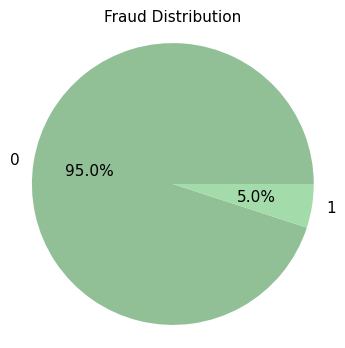

In [45]:
plt.figure(figsize=(4, 4))
plt.pie(Fraud_1['Is Fraudulent'].value_counts(), labels=Fraud_1['Is Fraudulent'].unique(), autopct='%1.1f%%', textprops={'fontsize': 11}, colors=['#91BF96', '#A3DBAA'])
plt.title('Fraud Distribution', fontsize=11)
plt.axis('equal')
plt.show()

## Distribution

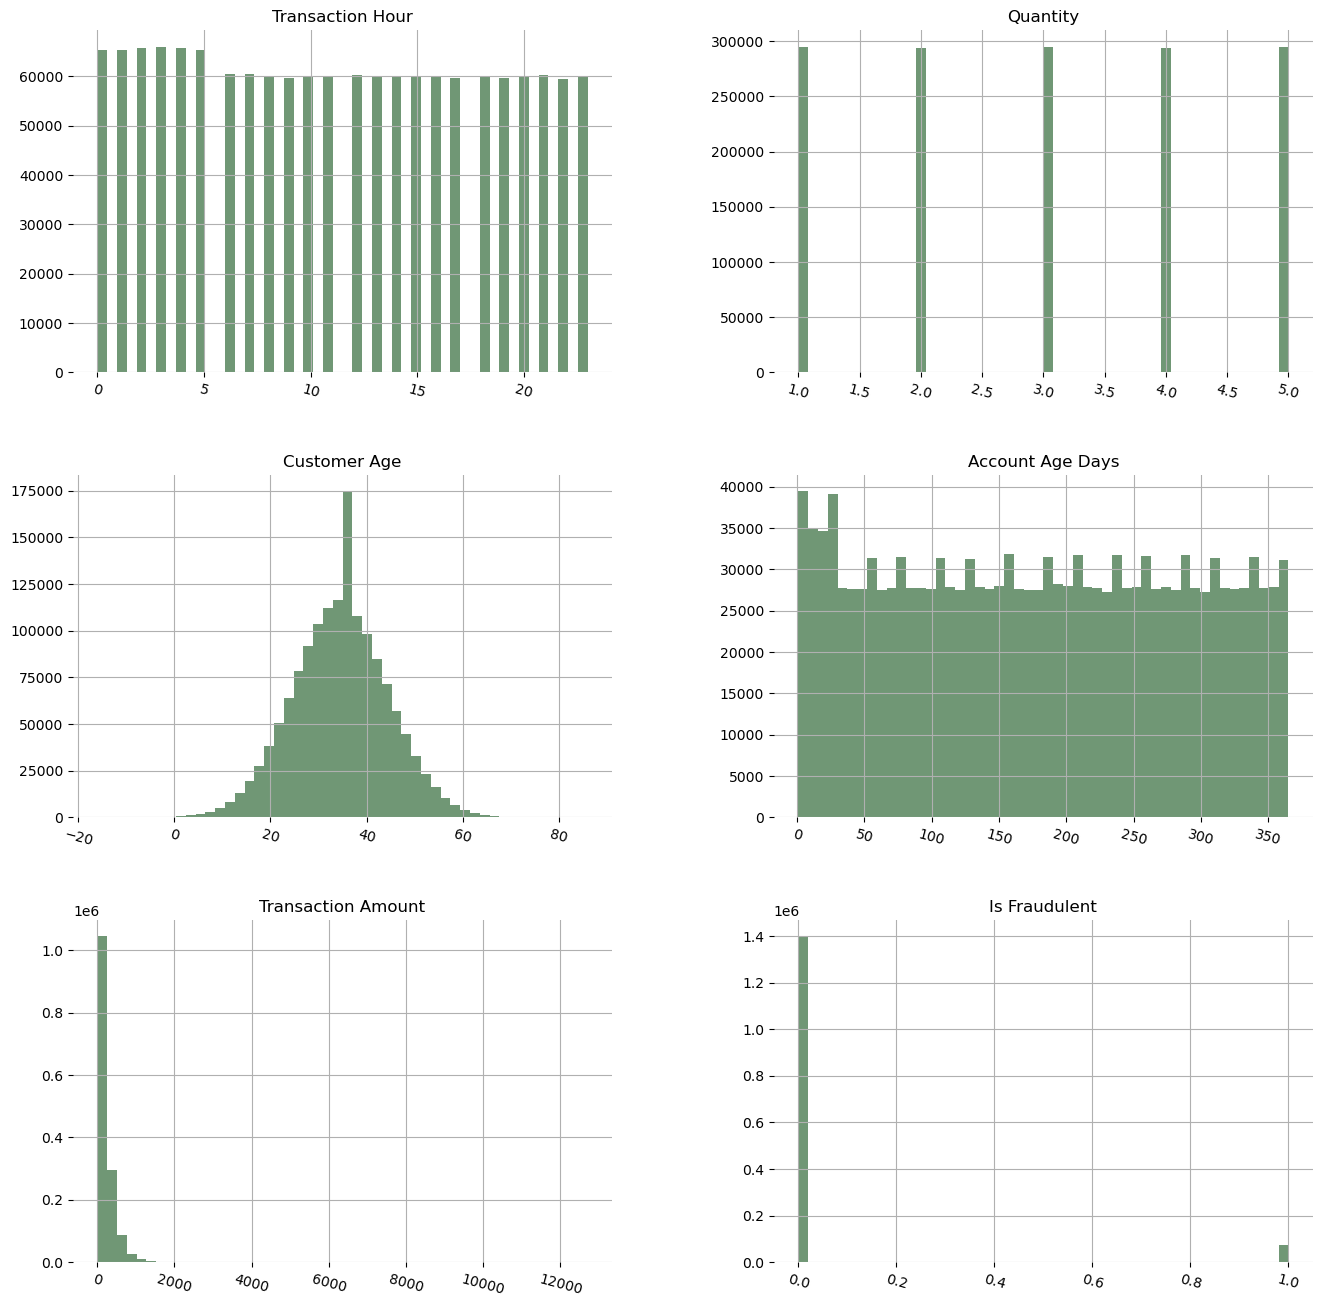

In [42]:
# Numerical Distribution
h = Fraud_1[numericals].hist(bins=50,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15, color='#709775')
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

- Distribusi pada **Transaction Amount** cenderung **right-skewed** dengan sebagian besar transaksi melibatkan jumlah yang lebih kecil dan hanya sedikit yang melibatkan jumlah yang besar
- Distribusi pada **Customer Age** grafik cenderung **symmetric** atau berdistribusi normal dengan sebagian besar customer berusia 30-40 tahun
- Distribusi Kuantitas cukup merata di antara 1 dan 5 
- Sebagian besar transaksi **not fraudulent**, menunjukkan data yang **imbalanced**.

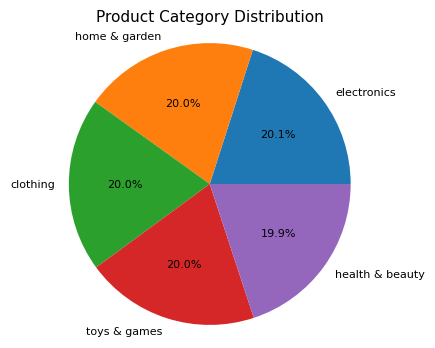

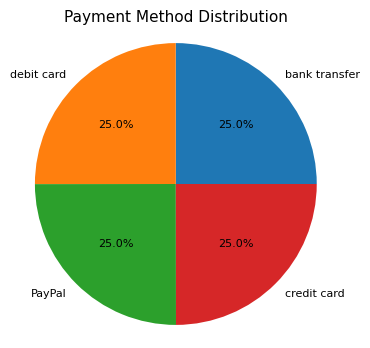

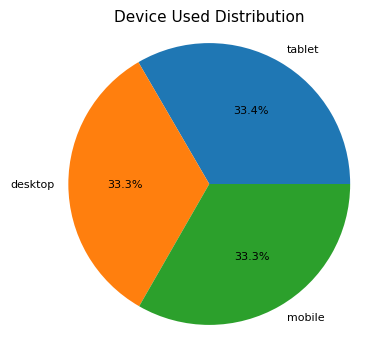

In [43]:
# Categorical Distribution
plt.figure(figsize=(4, 4))
plt.pie(Fraud_1['Product Category'].value_counts(), labels=Fraud_1['Product Category'].unique(), autopct='%1.1f%%', textprops={'fontsize': 8})
plt.title('Product Category Distribution', fontsize=11)
plt.axis('equal')
plt.show()

plt.figure(figsize=(4, 4))
plt.pie(Fraud_1['Payment Method'].value_counts(), labels=Fraud_1['Payment Method'].unique(), autopct='%1.1f%%', textprops={'fontsize': 8})
plt.title('Payment Method Distribution', fontsize=11)
plt.axis('equal')
plt.show()

plt.figure(figsize=(4, 4))
plt.pie(Fraud_1['Device Used'].value_counts(), labels=Fraud_1['Device Used'].unique(), autopct='%1.1f%%', textprops={'fontsize': 8})
plt.title('Device Used Distribution', fontsize=11)
plt.axis('equal')
plt.show()

In [10]:
#  Calculating the product with the highest number of fraudulent transactions
fraud_transactions= Fraud_1[(Fraud_1['Is Fraudulent']==1)]
fraud_item_count = fraud_transactions['Product Category'].value_counts()
fraud_item_count

Product Category
toys & games       14854
health & beauty    14821
clothing           14811
home & garden      14726
electronics        14626
Name: count, dtype: int64

Text(0.5, 1.0, 'Fraudulent Distribution Based on Product Category')

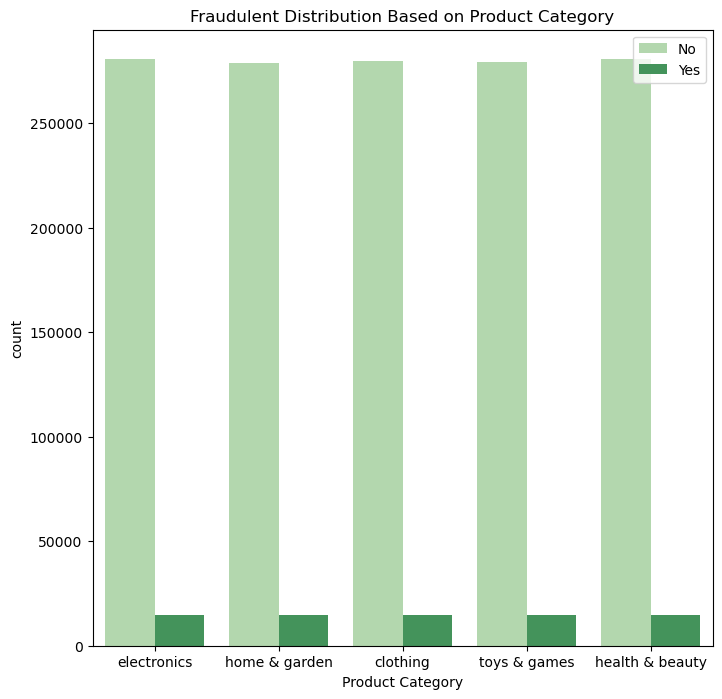

In [48]:
Fraud_1['Is Fraudulent'] = Fraud_1['Is Fraudulent'].astype(str)

plt.figure(figsize=(8,8))
sns.countplot(x="Product Category", data=Fraud_1, palette='Greens',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Product Category')

In [11]:
# Determining the highest number of fraudulent transactions based on age.
Jumlah_transaksi_aad = Fraud_1.groupby('Customer Age').agg({'Is Fraudulent': ['count']})
Jumlah_transaksi_aad

,Is Fraudulent
,count
Customer Age,
-16,1
-13,2
-12,3
-11,1
-10,2
...,...
78,7
79,4


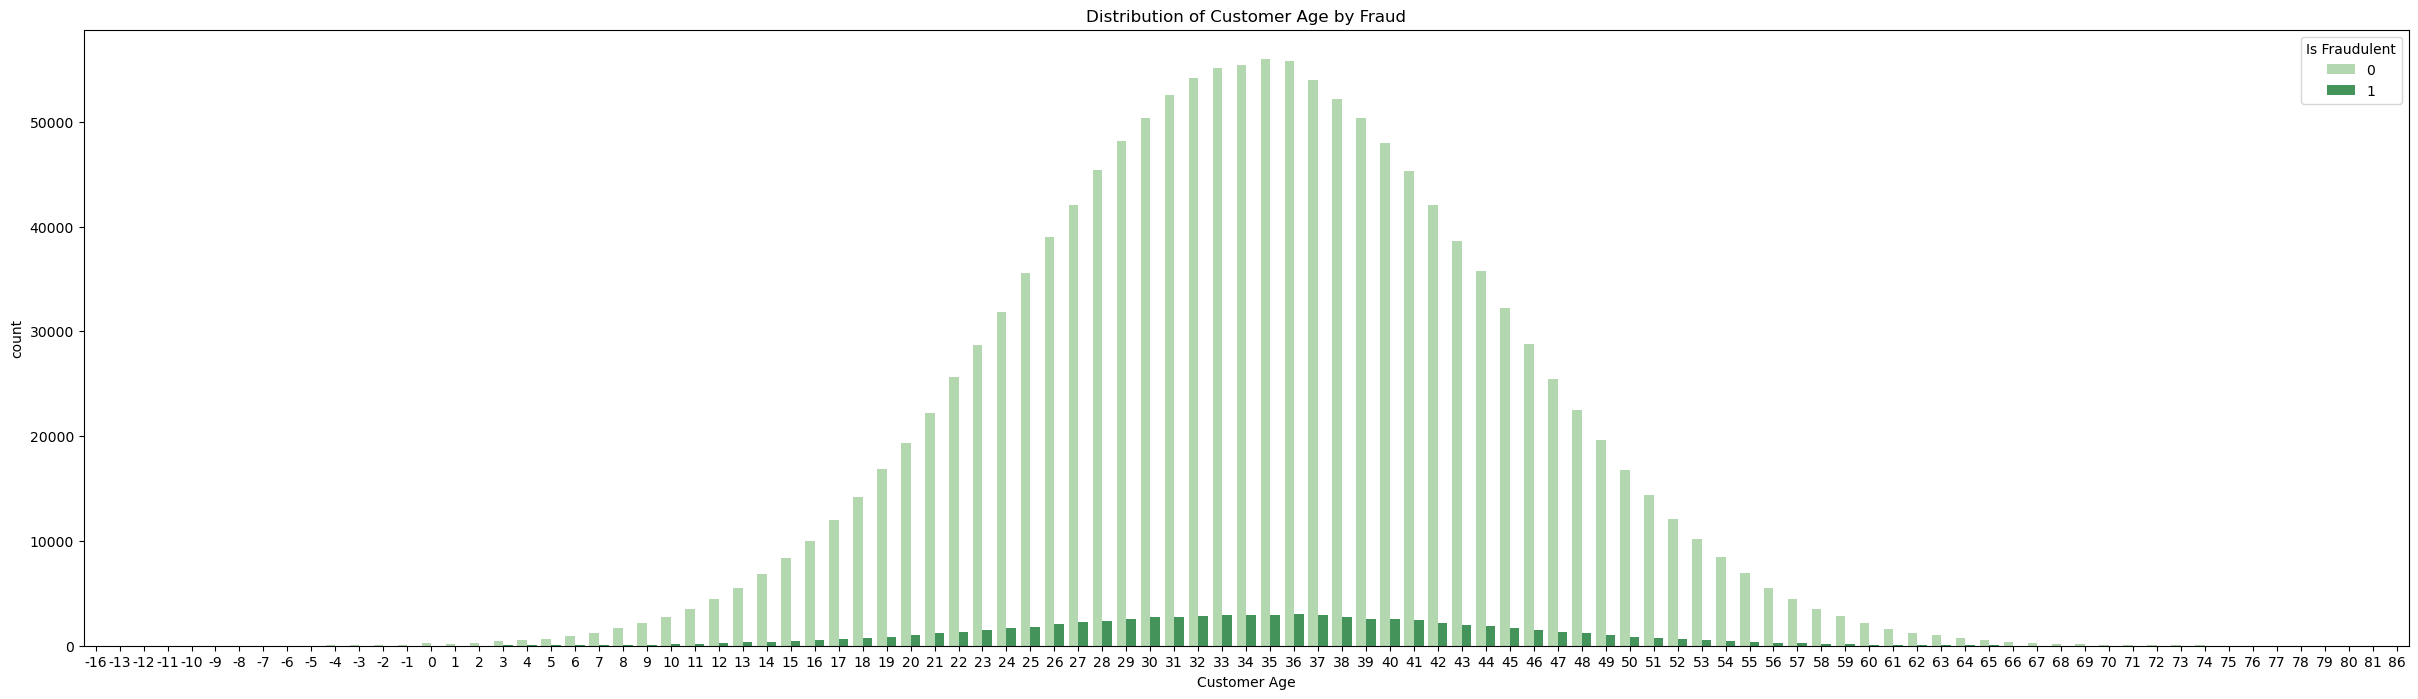

In [51]:
plt.figure(figsize=(30, 8))
sns.countplot(x='Customer Age', hue='Is Fraudulent', data=Fraud_1, palette='Greens')
plt.title('Distribution of Customer Age by Fraud')
plt.show()

In [12]:
#  Determining the month with the highest number of fraudulent transactions. 
Jumlah_transaksi = Fraud_1.groupby('Transaction Month').agg({'Is Fraudulent': ['count']})
Jumlah_transaksi

,Is Fraudulent
,count
Transaction Month,
April,36841
February,457863
January,489027
March,489221


Text(0.5, 1.0, 'Fraudulent Distribution Based on Transaction Month')

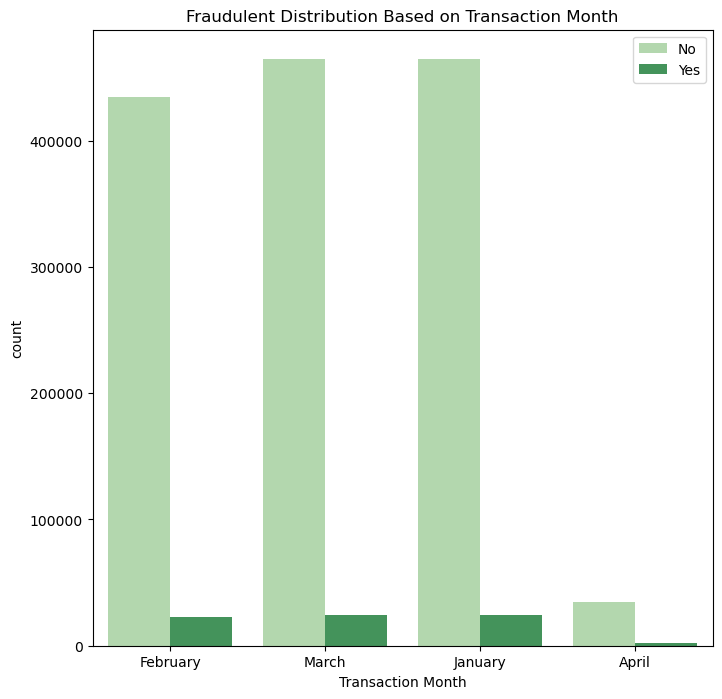

In [13]:
Fraud_1['Is Fraudulent'] = Fraud_1['Is Fraudulent'].astype(str)

plt.figure(figsize=(8,8))
sns.countplot(x="Transaction Month", data=Fraud_1, palette='Greens',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Transaction Month')

In [54]:
Jumlah_transaksi_aad = Fraud_1.groupby('Account Age Days').agg({'Is Fraudulent': ['count']})
Jumlah_transaksi_aad

,Is Fraudulent
,count
Account Age Days,
1,4910
2,4910
3,4873
4,4972
5,4979
...,...
361,3898
362,3950


Text(0.5, 1.0, 'Fraudulent Distribution Based on Account Age Day')

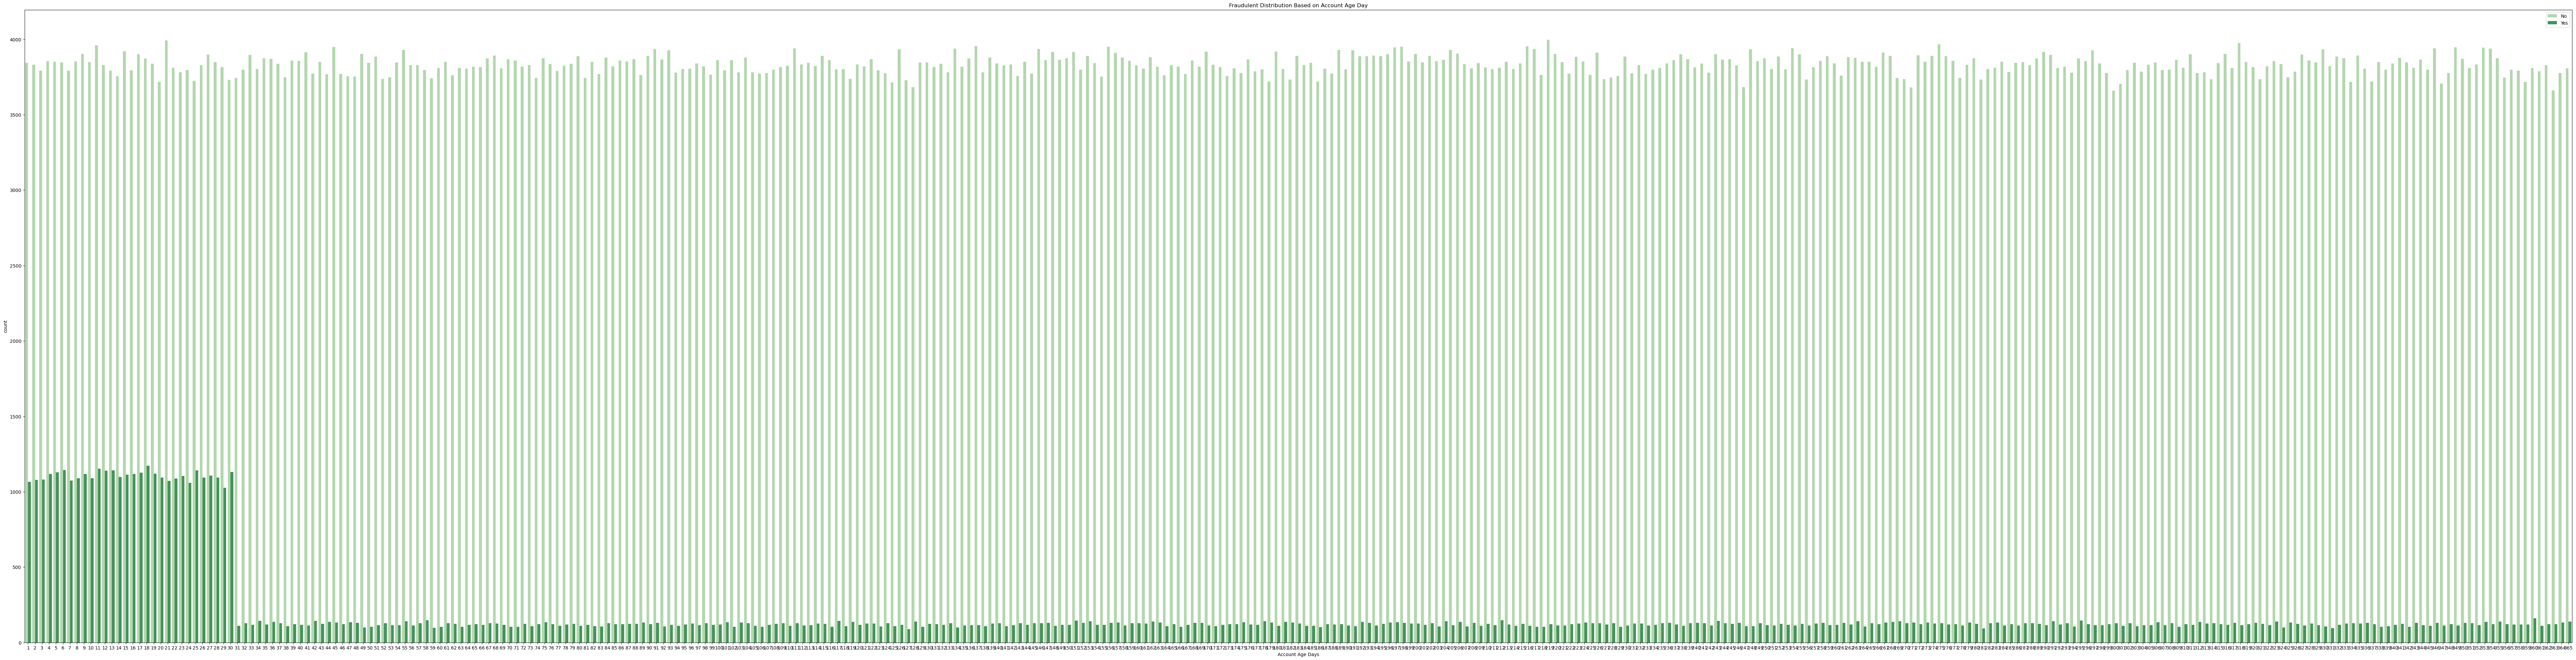

In [55]:
plt.figure(figsize=(100,25))
sns.countplot(x="Account Age Days", data=Fraud_1, palette='Greens',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Account Age Day')

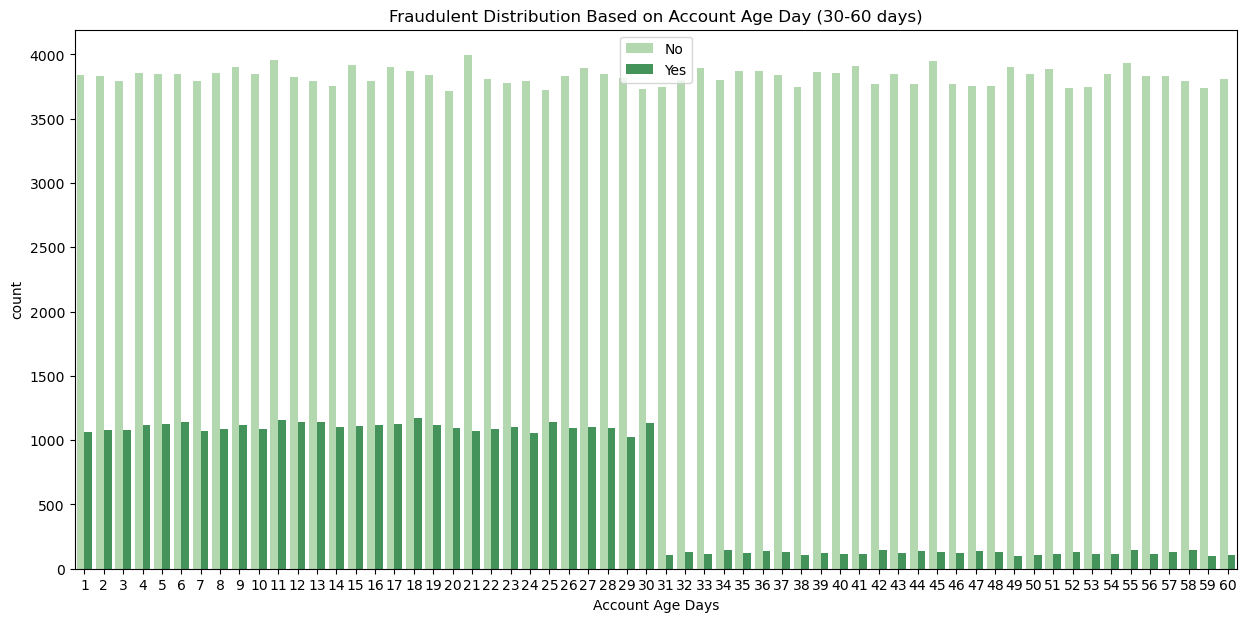

In [56]:
filtered_data = Fraud_1[(Fraud_1['Account Age Days'] >= 1) & (Fraud_1['Account Age Days'] <= 60)]

plt.figure(figsize=(15, 7))  # Adjust the figure size as needed
sns.countplot(x="Account Age Days", data=filtered_data, palette='Greens', hue='Is Fraudulent')
plt.legend(['No', 'Yes'])
plt.title('Fraudulent Distribution Based on Account Age Day (30-60 days)')
plt.show()

In [57]:
Jumlah_transaksi_hour = Fraud_1.groupby('Transaction Hour').agg({'Is Fraudulent': ['count']})
Jumlah_transaksi_hour

,Is Fraudulent
,count
Transaction Hour,
0,65438
1,65317
2,65693
3,66043
4,65721
5,65252
6,60577
7,60501


Text(0.5, 1.0, 'Fraudulent Distribution Based on Transaction Hour')

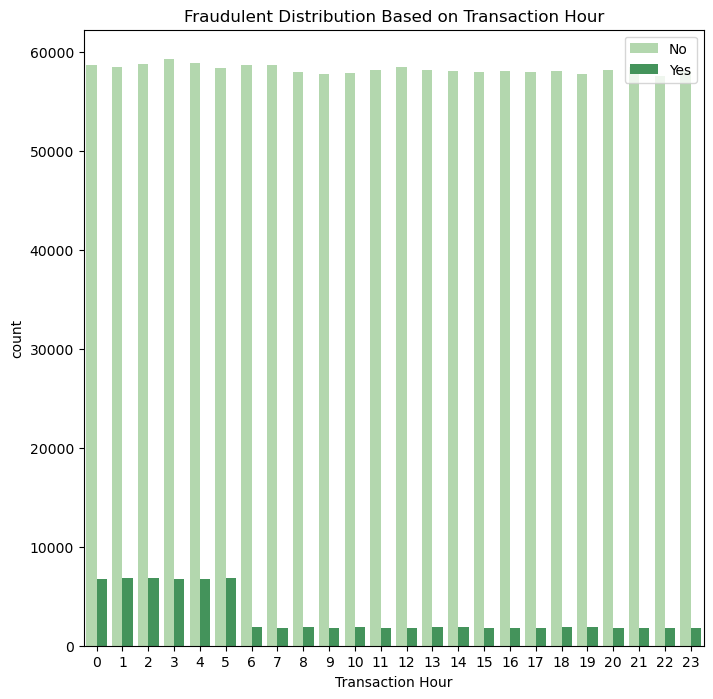

In [58]:
plt.figure(figsize=(8,8))
sns.countplot(x="Transaction Hour", data=Fraud_1, palette='Greens',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Transaction Hour')

In [59]:
Jumlah_transaksi_hour = Fraud_1.groupby('Customer Location').agg({'Is Fraudulent': ['count']})
Jumlah_transaksi_hour

,Is Fraudulent
,count
Customer Location,
Aaronberg,62
Aaronborough,73
Aaronburgh,77
Aaronbury,68
Aaronchester,65
...,...
Zunigastad,4
Zunigaton,5


In [60]:
top10_cust_location = (Fraud_1
            .groupby('Customer Location')
            .agg(fraud_count=('Is Fraudulent','count'))
            .reset_index()
            .sort_values('fraud_count',ascending=False)
            .head(10)
            )
top10_cust_location

,Customer Location,fraud_count
46918,New Michael,1258
82298,South Michael,1209
14944,East Michael,1206
68722,Port Michael,1204
95211,West Michael,1201
32562,Lake Michael,1198
57286,North Michael,1162
38814,Michaelmouth,891
90799,West David,869
42519,New David,855


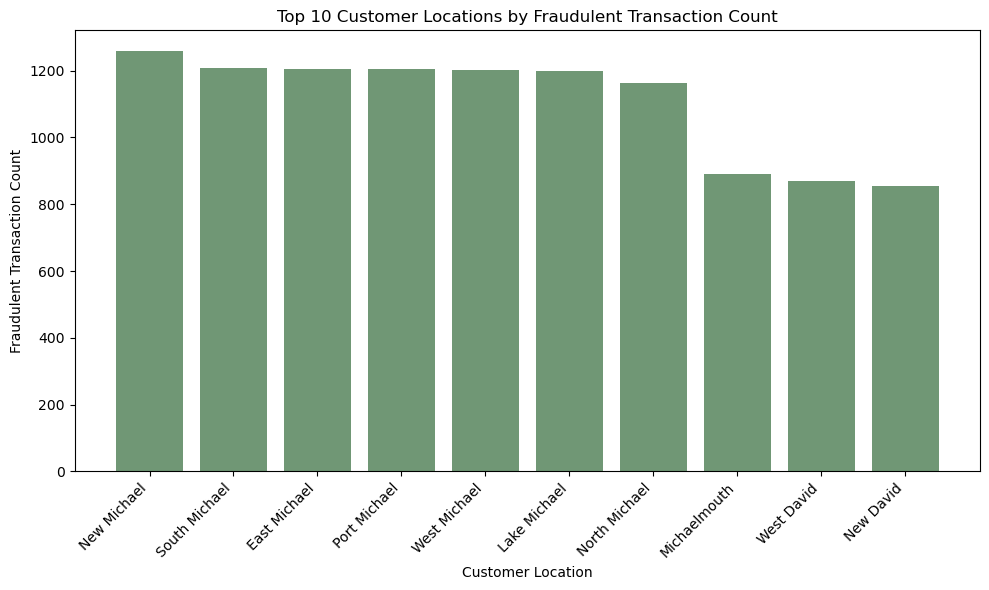

In [61]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(top10_cust_location['Customer Location'], top10_cust_location['fraud_count'], color='#709775')
plt.title('Top 10 Customer Locations by Fraudulent Transaction Count')
plt.xlabel('Customer Location')
plt.ylabel('Fraudulent Transaction Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

- There were **73,838 transactions** involving fraudulent incidents, resulting in **$40,449,950** in losses.
- The product category **toys&games** had **the highest number of transactions** involving fraudulent incidents, followed by health&beauty and clothing.
- **January and March** had **the highest number of transactions** involving fraudulent incidents and financial losses, with a significant drop in April. This is due to data collection limitations, which ceased at the beginning of April.
- **People aged 30-39** are **most vulnerable** to e-commerce fraud. This is likely due to high usage of technology but lesser familiarity with risks associated with online payments.
- Most **cases of fraud** occur within **1 hour to 5 hours after transactions** are made.
- The **account age** with the highest number of fraudulent incidents is **1 month**.

## Correlation Heatmap

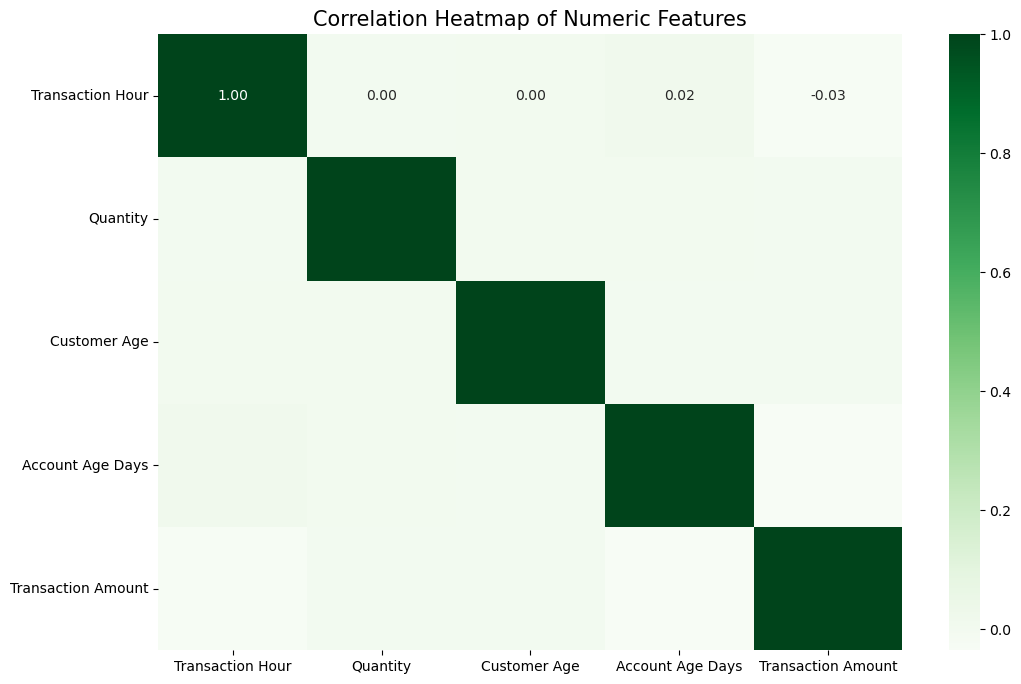

In [62]:
numericals = Fraud_1.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
correlation_matrix = numericals.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features', fontsize=15)
plt.show()

# Feature Engineering

In [63]:
categorical = Fraud_1.select_dtypes(include=['object']).columns.tolist()
categorical

['Transaction ID',
 'Customer ID',
 'Transaction Month',
 'Product Category',
 'Payment Method',
 'Device Used',
 'Customer Location',
 'IP Address',
 'Shipping Address',
 'Billing Address',
 'Is Fraudulent']

In [64]:
map_PaymentMethod = { 'bank transfer' : 4, 'PayPal':3, 'credit card':2, 'debit card':1}
Fraud['PaymentMethod_cat'] = Fraud['Payment Method'].map(map_PaymentMethod)

In [65]:
map_ProductCategory = { 'home & garden' : 5, 'electronics' : 4, 'clothing':3, 'health & beauty':2, 'toys & games':1}
Fraud['ProductCategory_cat'] = Fraud['Product Category'].map(map_ProductCategory)

In [66]:
map_DeviceUsed = {'tablet':3, 'desktop':2, 'mobile':1}
Fraud['DeviceUsed_cat'] = Fraud['Device Used'].map(map_DeviceUsed)

In [67]:
map_TransactionMonth = {'April':4, 'March':3, 'February':2, 'January':1}
Fraud['TransactionMonth_cat'] = Fraud['Transaction Month'].map(map_TransactionMonth)

In [68]:
label_encoder = LabelEncoder()
Fraud['Customer_Location_encoded'] = label_encoder.fit_transform(Fraud['Customer Location'])

In [69]:
label_encoder = LabelEncoder()
Fraud['Encoded_Shipping_Address'] = label_encoder.fit_transform(Fraud['Shipping Address'])

In [70]:
def encode_ip(ip):
    parts = ip.split('.')
    return int(parts[0]) * 256**3 + int(parts[1]) * 256**2 + int(parts[2]) * 256 + int(parts[3])

Fraud['Encoded_IP_Address'] = Fraud['IP Address'].apply(encode_ip)

## Modelling

### Baseline Model

In [71]:
fraud_2= Fraud[[ 'Transaction Amount', 'Quantity','Customer Age','Account Age Days','Transaction Hour','Transaction Year','Transaction Day', 
                'PaymentMethod_cat','DeviceUsed_cat','ProductCategory_cat','TransactionMonth_cat', 'Customer_Location_encoded', 'Encoded_IP_Address',
                'Encoded_Shipping_Address', 'Is Fraudulent']]

In [72]:
X = fraud_2.drop(['Is Fraudulent'], axis=1)
y = fraud_2['Is Fraudulent']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [73]:
# Decision Tree
model_1 = DecisionTreeClassifier()
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96    419736
           1       0.21      0.25      0.23     22150

    accuracy                           0.92    441886
   macro avg       0.59      0.60      0.59    441886
weighted avg       0.92      0.92      0.92    441886



In [74]:
# Random Forest
model_2 = RandomForestClassifier(n_estimators=100)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    419736
           1       0.80      0.15      0.25     22150

    accuracy                           0.96    441886
   macro avg       0.88      0.57      0.61    441886
weighted avg       0.95      0.96      0.94    441886



In [75]:
# XGBoost
model_4 = XGBClassifier(n_estimators=100)
model_4.fit(X_train, y_train)
y_pred = model_4.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    419736
           1       0.80      0.15      0.26     22150

    accuracy                           0.96    441886
   macro avg       0.88      0.57      0.62    441886
weighted avg       0.95      0.96      0.94    441886



In [76]:
# Cat Boost
model_3 = CatBoostClassifier(iterations=100, learning_rate=0.1,  # Learning rate
                           depth=6,  # Depth of trees
                           loss_function='Logloss',  # Loss function to optimize
                           eval_metric='Accuracy')
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)
print(classification_report(y_test,y_pred))

0:	learn: 0.9549544	total: 226ms	remaining: 22.4s
1:	learn: 0.9552424	total: 279ms	remaining: 13.7s
2:	learn: 0.9554093	total: 326ms	remaining: 10.6s
3:	learn: 0.9552812	total: 368ms	remaining: 8.83s
4:	learn: 0.9553132	total: 409ms	remaining: 7.77s
5:	learn: 0.9553811	total: 453ms	remaining: 7.09s
6:	learn: 0.9553229	total: 498ms	remaining: 6.62s
7:	learn: 0.9553152	total: 540ms	remaining: 6.21s
8:	learn: 0.9553385	total: 579ms	remaining: 5.86s
9:	learn: 0.9553918	total: 619ms	remaining: 5.57s
10:	learn: 0.9554054	total: 660ms	remaining: 5.34s
11:	learn: 0.9554131	total: 701ms	remaining: 5.14s
12:	learn: 0.9554364	total: 742ms	remaining: 4.96s
13:	learn: 0.9554771	total: 783ms	remaining: 4.81s
14:	learn: 0.9555024	total: 826ms	remaining: 4.68s
15:	learn: 0.9555479	total: 869ms	remaining: 4.56s
16:	learn: 0.9555538	total: 909ms	remaining: 4.44s
17:	learn: 0.9555615	total: 952ms	remaining: 4.34s
18:	learn: 0.9555538	total: 996ms	remaining: 4.24s
19:	learn: 0.9555887	total: 1.04s	remaini

### Baseline Model + Undersampling + SMOTE

In [77]:
X = fraud_2.drop(['Is Fraudulent'], axis=1)
y = fraud_2['Is Fraudulent']


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [78]:
from collections import Counter

# Perform under-sampling
under_sampler = RandomUnderSampler(sampling_strategy=0.5)  # Adjust strategy as needed
X_resampled, y_resampled = under_sampler.fit_resample(X_train , y_train)

# Apply SMOTE
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X_resampled, y_resampled)

# Check the distribution
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_balanced))

Original dataset shape Counter({0: 1399114, 1: 73838})
Resampled dataset shape Counter({0: 103374, 1: 103374})


In [79]:
# Decision Tree
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_balanced, y_balanced)
y_pred = model_DTC.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.67      0.80    419735
           1       0.09      0.61      0.16     22151

    accuracy                           0.67    441886
   macro avg       0.53      0.64      0.48    441886
weighted avg       0.93      0.67      0.76    441886



In [80]:
# Random Forest
model_RF = RandomForestClassifier(n_estimators=100)
model_RF.fit(X_balanced, y_balanced)
y_pred = model_RF.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.88    419735
           1       0.15      0.63      0.24     22151

    accuracy                           0.80    441886
   macro avg       0.56      0.72      0.56    441886
weighted avg       0.94      0.80      0.85    441886



In [81]:
# Model XGB
model_XGB = XGBClassifier(n_estimators=100)
model_XGB.fit(X_balanced, y_balanced)
y_pred = model_XGB.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88    419735
           1       0.14      0.64      0.23     22151

    accuracy                           0.79    441886
   macro avg       0.56      0.72      0.55    441886
weighted avg       0.93      0.79      0.85    441886



In [89]:
# Model CatBoost
model_CB = CatBoostClassifier(iterations=100, learning_rate=0.1,  # Learning rate
                           depth=6,  # Depth of trees
                           loss_function='Logloss',  # Loss function to optimize
                           eval_metric='Accuracy')
model_CB.fit(X_balanced, y_balanced)
y_pred_CB = model_CB.predict(X_test)
print(classification_report(y_test,y_pred))

0:	learn: 0.7280119	total: 11.1ms	remaining: 1.09s
1:	learn: 0.7282344	total: 20.6ms	remaining: 1.01s
2:	learn: 0.7330663	total: 29.5ms	remaining: 955ms
3:	learn: 0.7338741	total: 38.9ms	remaining: 934ms
4:	learn: 0.7362490	total: 48.3ms	remaining: 919ms
5:	learn: 0.7372599	total: 57.3ms	remaining: 897ms
6:	learn: 0.7402587	total: 66ms	remaining: 878ms
7:	learn: 0.7403893	total: 74.8ms	remaining: 860ms
8:	learn: 0.7412405	total: 84.3ms	remaining: 853ms
9:	learn: 0.7429092	total: 93.8ms	remaining: 844ms
10:	learn: 0.7429189	total: 103ms	remaining: 832ms
11:	learn: 0.7423917	total: 113ms	remaining: 830ms
12:	learn: 0.7431124	total: 122ms	remaining: 815ms
13:	learn: 0.7446698	total: 132ms	remaining: 811ms
14:	learn: 0.7448391	total: 141ms	remaining: 801ms
15:	learn: 0.7462370	total: 150ms	remaining: 789ms
16:	learn: 0.7463869	total: 159ms	remaining: 776ms
17:	learn: 0.7465852	total: 168ms	remaining: 763ms
18:	learn: 0.7473301	total: 177ms	remaining: 753ms
19:	learn: 0.7483893	total: 186ms

In [90]:
from sklearn.metrics import confusion_matrix

cm_CB = confusion_matrix(y_test, y_pred_CB)

# Extract TP, TN, FP, FN from the confusion matrix
TP = cm_CB[1, 1]
TN = cm_CB[0, 0]
FP = cm_CB[0, 1]
FN = cm_CB[1, 0]

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

True Positives: 14356
True Negatives: 334110
False Positives: 85625
False Negatives: 7795


Area Under Curve (AUC) for Precision-Recall Curve: 0.3376456804442121
Average Precision Score: 0.3376571643762758


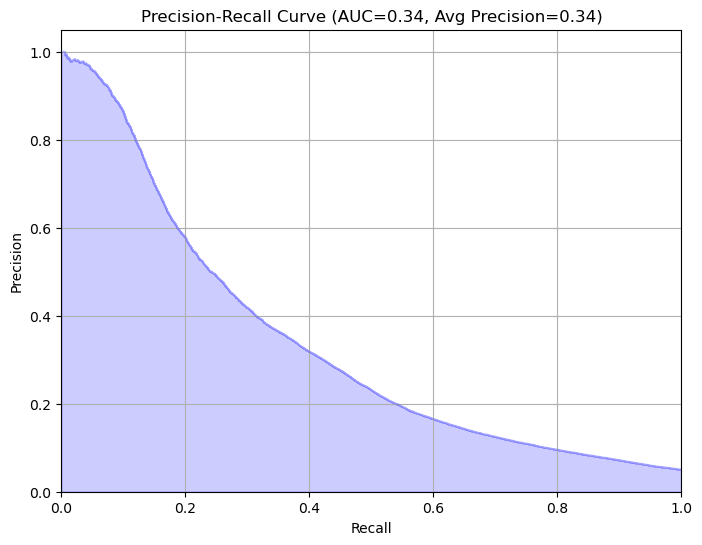

In [97]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.datasets import make_classification

# Predict probabilities on the test set
y_prob = model_CB.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate area under curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)
print(f"Area Under Curve (AUC) for Precision-Recall Curve: {auc_score}")

# Calculate average precision score
avg_precision = average_precision_score(y_test, y_prob)
print(f"Average Precision Score: {avg_precision}")

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve (AUC={auc_score:.2f}, Avg Precision={avg_precision:.2f})')
plt.grid(True)
plt.show()